# Wavelet Denoising for Acoustic Data

This notebook demonstrates wavelet-based denoising techniques for underwater acoustic recordings using the EARS reader module.

## Overview

Wavelet denoising is a powerful technique for removing noise from signals while preserving important features like transients and clicks. It works by:

1. **Decomposing** the signal into wavelet coefficients at different scales
2. **Thresholding** the coefficients to remove noise components
3. **Reconstructing** the signal from the thresholded coefficients

### The Universal Threshold (VisuShrink)

We use the VisuShrink method (Donoho & Johnstone, 1994):

$$\text{threshold} = \sigma \times \sqrt{2 \times \ln(N)}$$

where:
- **σ** is estimated from the Median Absolute Deviation (MAD) of the finest-scale wavelet coefficients
- **N** is the signal length

### Key Features

- **Preserves transients**: Unlike frequency-domain filtering, wavelets preserve sharp features
- **Adaptive**: Threshold automatically adjusts to signal characteristics
- **Multi-resolution**: Denoises at multiple time scales simultaneously

In [2]:
# Import the EARS reader module
import dolphain
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

%matplotlib inline

## Example 1: Basic Wavelet Denoising

Let's start by loading a sample file and applying basic wavelet denoising with default parameters.

In [3]:
# Read a sample file
file_path = Path('unophysics/sample_data/71621DC7.190')
data = dolphain.read_ears_file(file_path)

dolphain.print_file_info(data, file_path)

File: unophysics/sample_data/71621DC7.190
Recording start: 2017-06-12 06:38:38.348219
Recording end: 2017-06-12 06:38:59.681552
Duration: 21.33 seconds
Number of samples: 4,096,000
Sampling rate: 192,000 Hz


In [4]:
# Apply wavelet denoising with default parameters (Daubechies 20 wavelet)
acoustic_data = data['data']
denoised_data, threshold_used = dolphain.wavelet_denoise(
    acoustic_data, 
    return_threshold=True
)

print(f"Automatic threshold calculated: {threshold_used:.2f}")
print(f"Original data RMS: {np.sqrt(np.mean(acoustic_data**2)):.2f}")
print(f"Denoised data RMS: {np.sqrt(np.mean(denoised_data**2)):.2f}")
print(f"Noise reduction: {(1 - np.sqrt(np.mean(denoised_data**2)) / np.sqrt(np.mean(acoustic_data**2))) * 100:.1f}%")

Automatic threshold calculated: 10.57
Original data RMS: 180.24
Denoised data RMS: 8.37
Noise reduction: 95.4%


## Example 2: Visual Comparison

Compare the original and denoised data using time-domain waveforms and spectrograms.

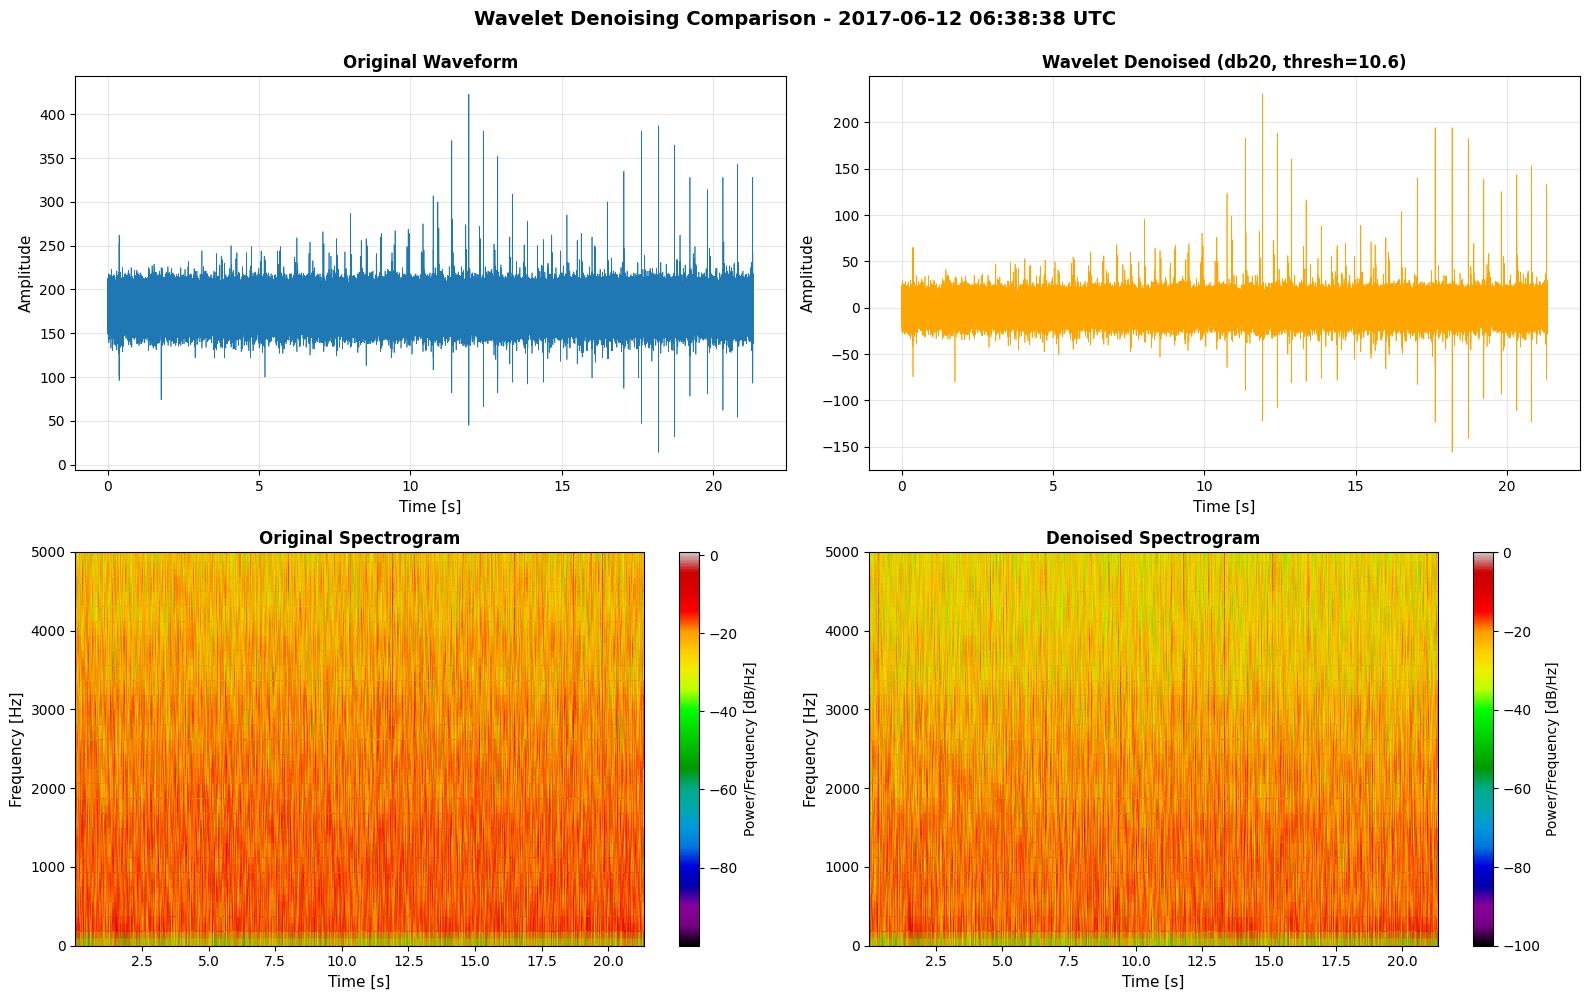

In [5]:
# Create comprehensive comparison plot
dolphain.plot_denoising_comparison(data, fmax=5000)

## Example 3: Zoomed View

Zoom into a specific time window to see the details of how wavelet denoising preserves transient features.

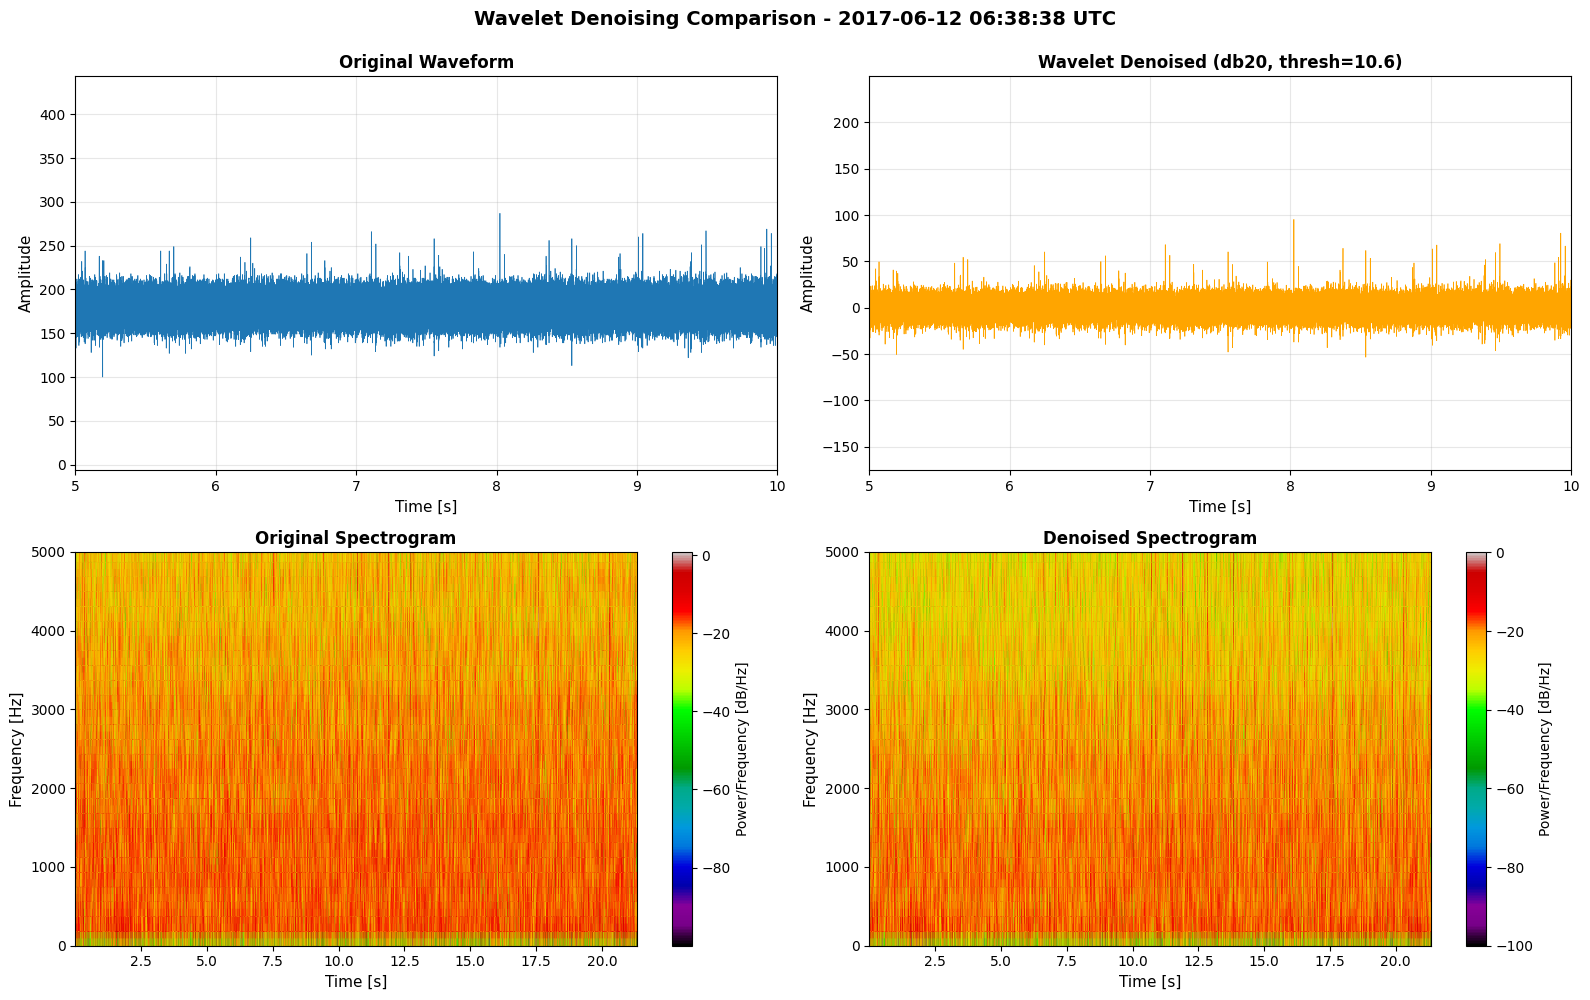

In [6]:
# Zoom into a specific time window to see details
dolphain.plot_denoising_comparison(data, xlim=(5, 10), fmax=5000)

## Example 4: Comparing Different Wavelets

Different wavelet families have different characteristics:

- **db4, db8, db20**: Daubechies wavelets (increasing smoothness with higher order)
- **sym8**: Symlets (more symmetric than Daubechies)
- **coif5**: Coiflets (symmetric with vanishing moments)

Higher-order wavelets (like db20) tend to produce smoother results, while lower-order wavelets preserve more high-frequency details.

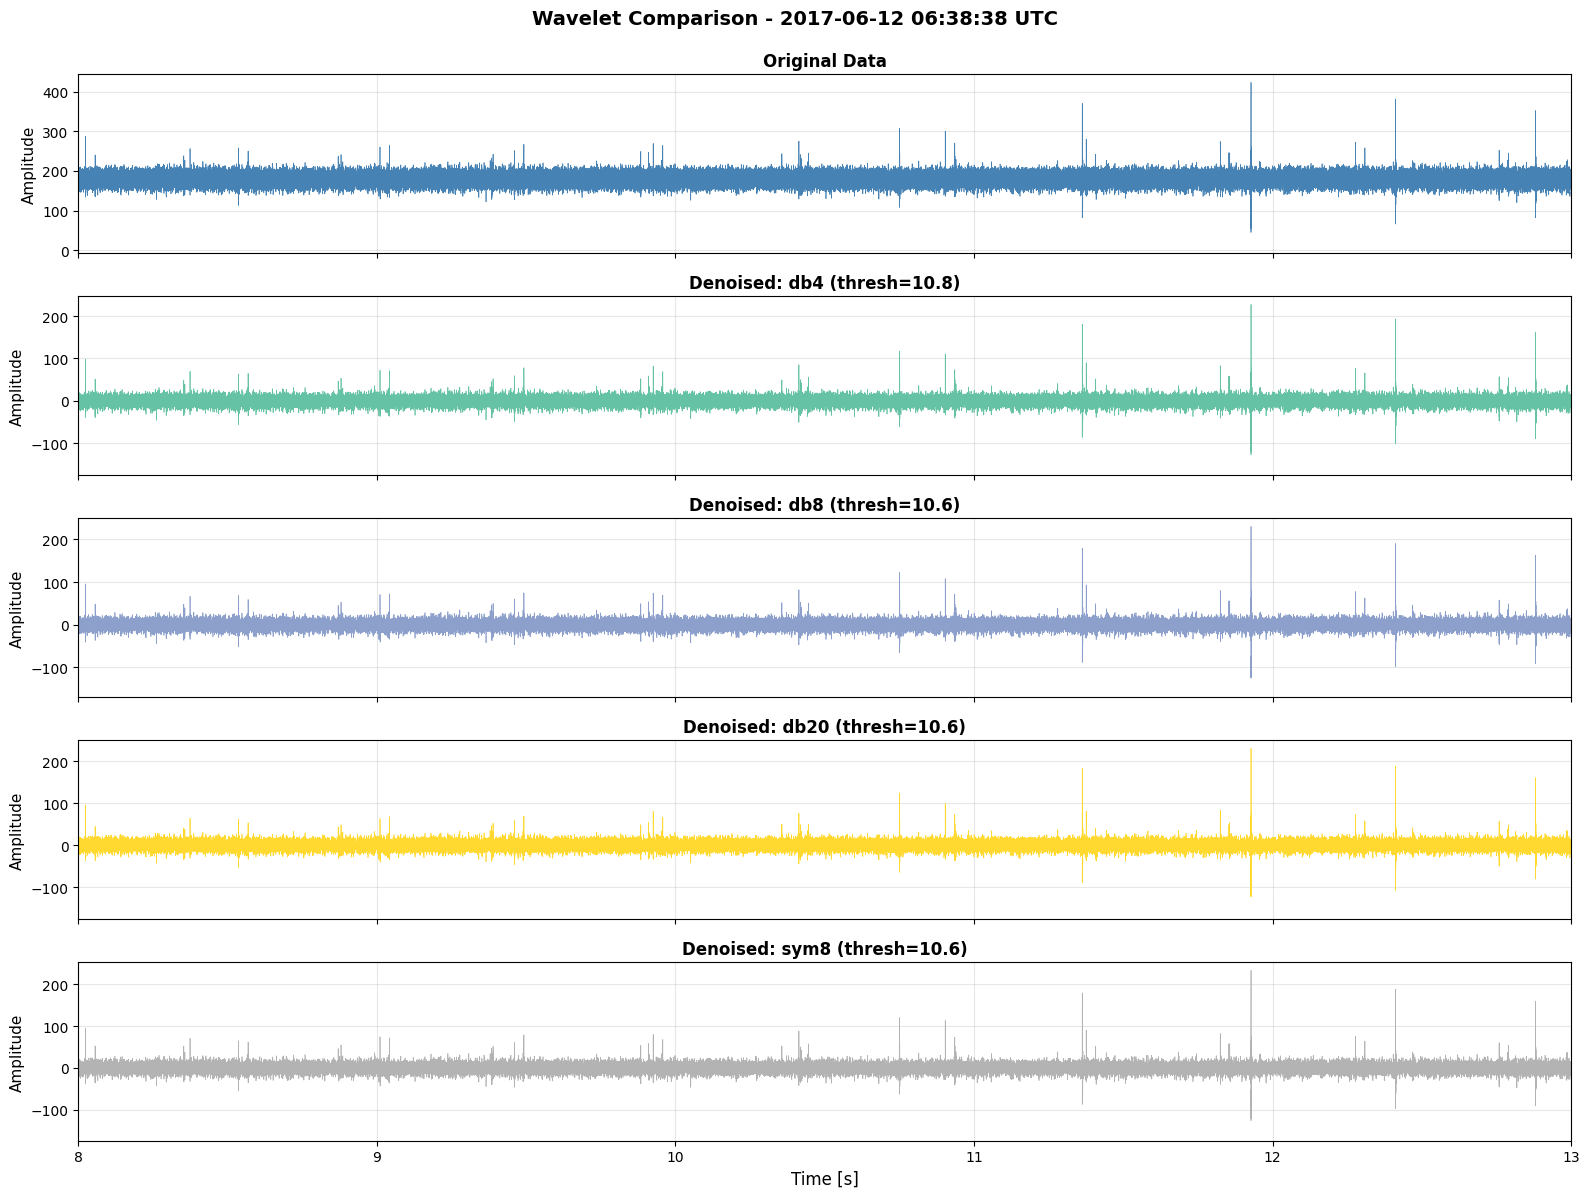

In [7]:
# Compare different wavelet types
dolphain.plot_wavelet_comparison(
    data, 
    wavelets=['db4', 'db8', 'db20', 'sym8'],
    xlim=(8, 13)
)

## Example 5: Hard vs Soft Thresholding

There are two main types of thresholding:

### Soft Thresholding (default)
- Shrinks coefficients towards zero by the threshold amount
- Produces smoother, more continuous results
- Better for removing Gaussian noise

### Hard Thresholding
- Keeps coefficients above threshold unchanged, zeros out the rest
- Preserves more sharp features and discontinuities
- Can introduce artifacts at threshold boundaries

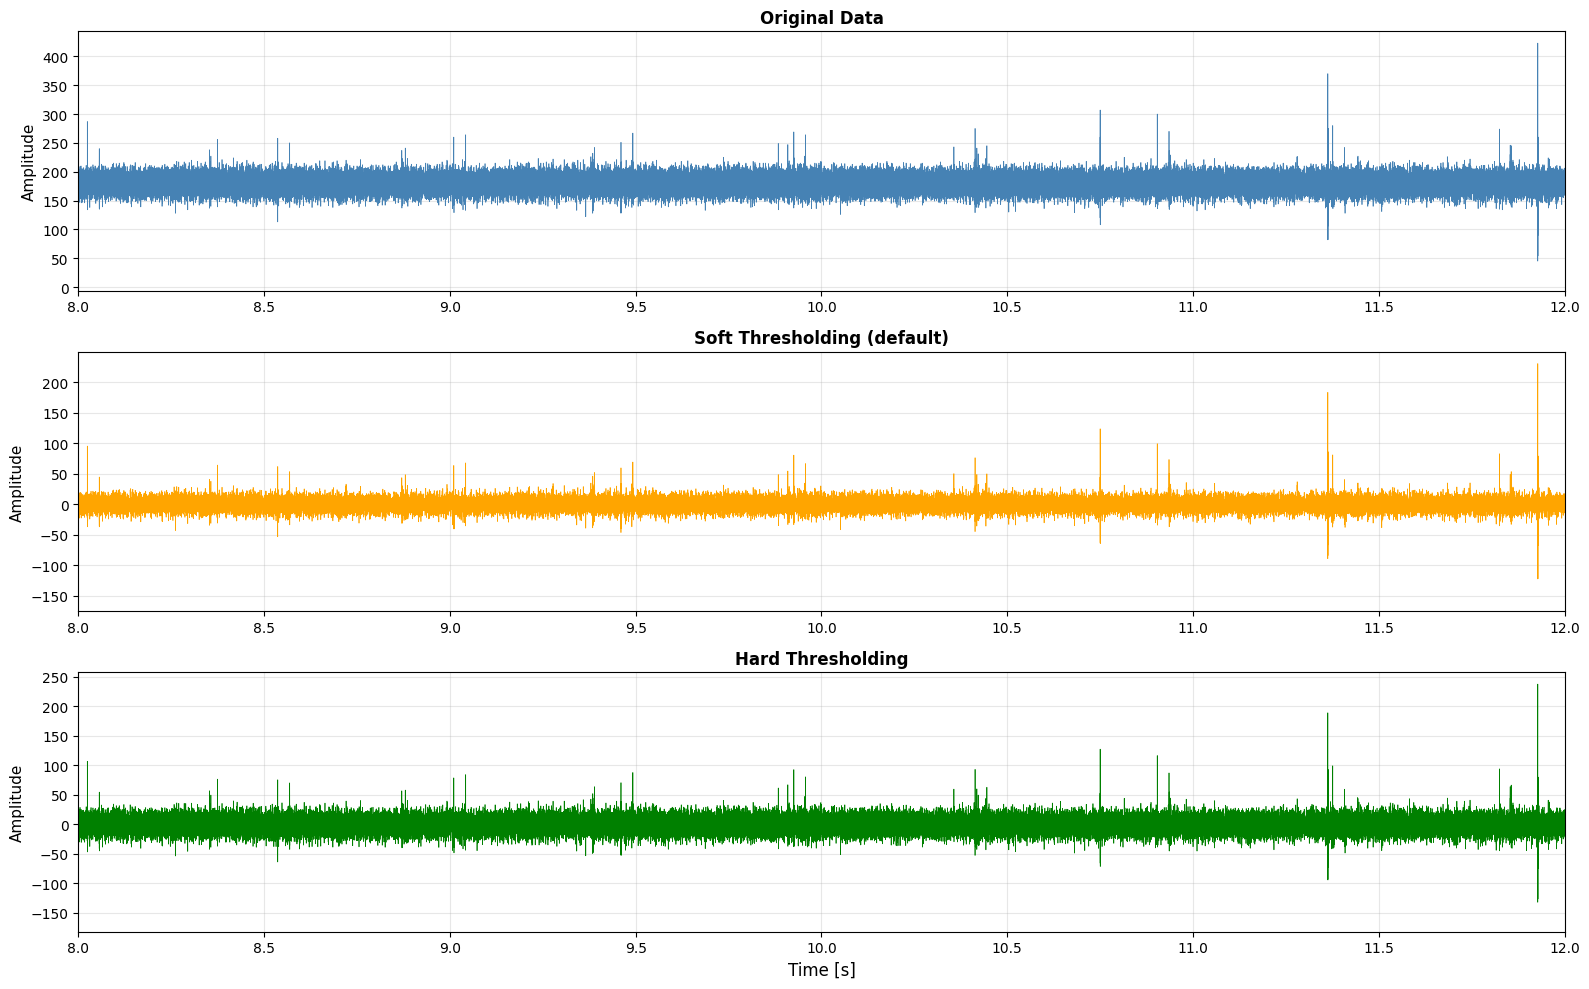

Soft thresholding: Shrinks coefficients towards zero (smoother results)
Hard thresholding: Keeps or zeros coefficients (preserves more details)


In [8]:
# Apply both hard and soft thresholding
soft_denoised = dolphain.wavelet_denoise(acoustic_data, hard_threshold=False)
hard_denoised = dolphain.wavelet_denoise(acoustic_data, hard_threshold=True)

# Create time array
time = np.linspace(0, data['duration'], len(acoustic_data))

# Plot comparison
fig, axes = plt.subplots(3, 1, figsize=(16, 10))

xlim = (8, 12)

axes[0].plot(time, acoustic_data, linewidth=0.5, color='steelblue')
axes[0].set_ylabel('Amplitude', fontsize=11)
axes[0].set_title('Original Data', fontsize=12, fontweight='bold')
axes[0].set_xlim(xlim)
axes[0].grid(True, alpha=0.3)

axes[1].plot(time, soft_denoised, linewidth=0.5, color='orange')
axes[1].set_ylabel('Amplitude', fontsize=11)
axes[1].set_title('Soft Thresholding (default)', fontsize=12, fontweight='bold')
axes[1].set_xlim(xlim)
axes[1].grid(True, alpha=0.3)

axes[2].plot(time, hard_denoised, linewidth=0.5, color='green')
axes[2].set_xlabel('Time [s]', fontsize=12)
axes[2].set_ylabel('Amplitude', fontsize=11)
axes[2].set_title('Hard Thresholding', fontsize=12, fontweight='bold')
axes[2].set_xlim(xlim)
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Soft thresholding: Shrinks coefficients towards zero (smoother results)")
print("Hard thresholding: Keeps or zeros coefficients (preserves more details)")

## Example 6: Custom Threshold

You can override the automatic threshold for more aggressive or conservative denoising:

- **Lower threshold** (e.g., `0.5 × auto`): More conservative, keeps more of the original signal
- **Higher threshold** (e.g., `2.0 × auto`): More aggressive, removes more noise but may lose signal details

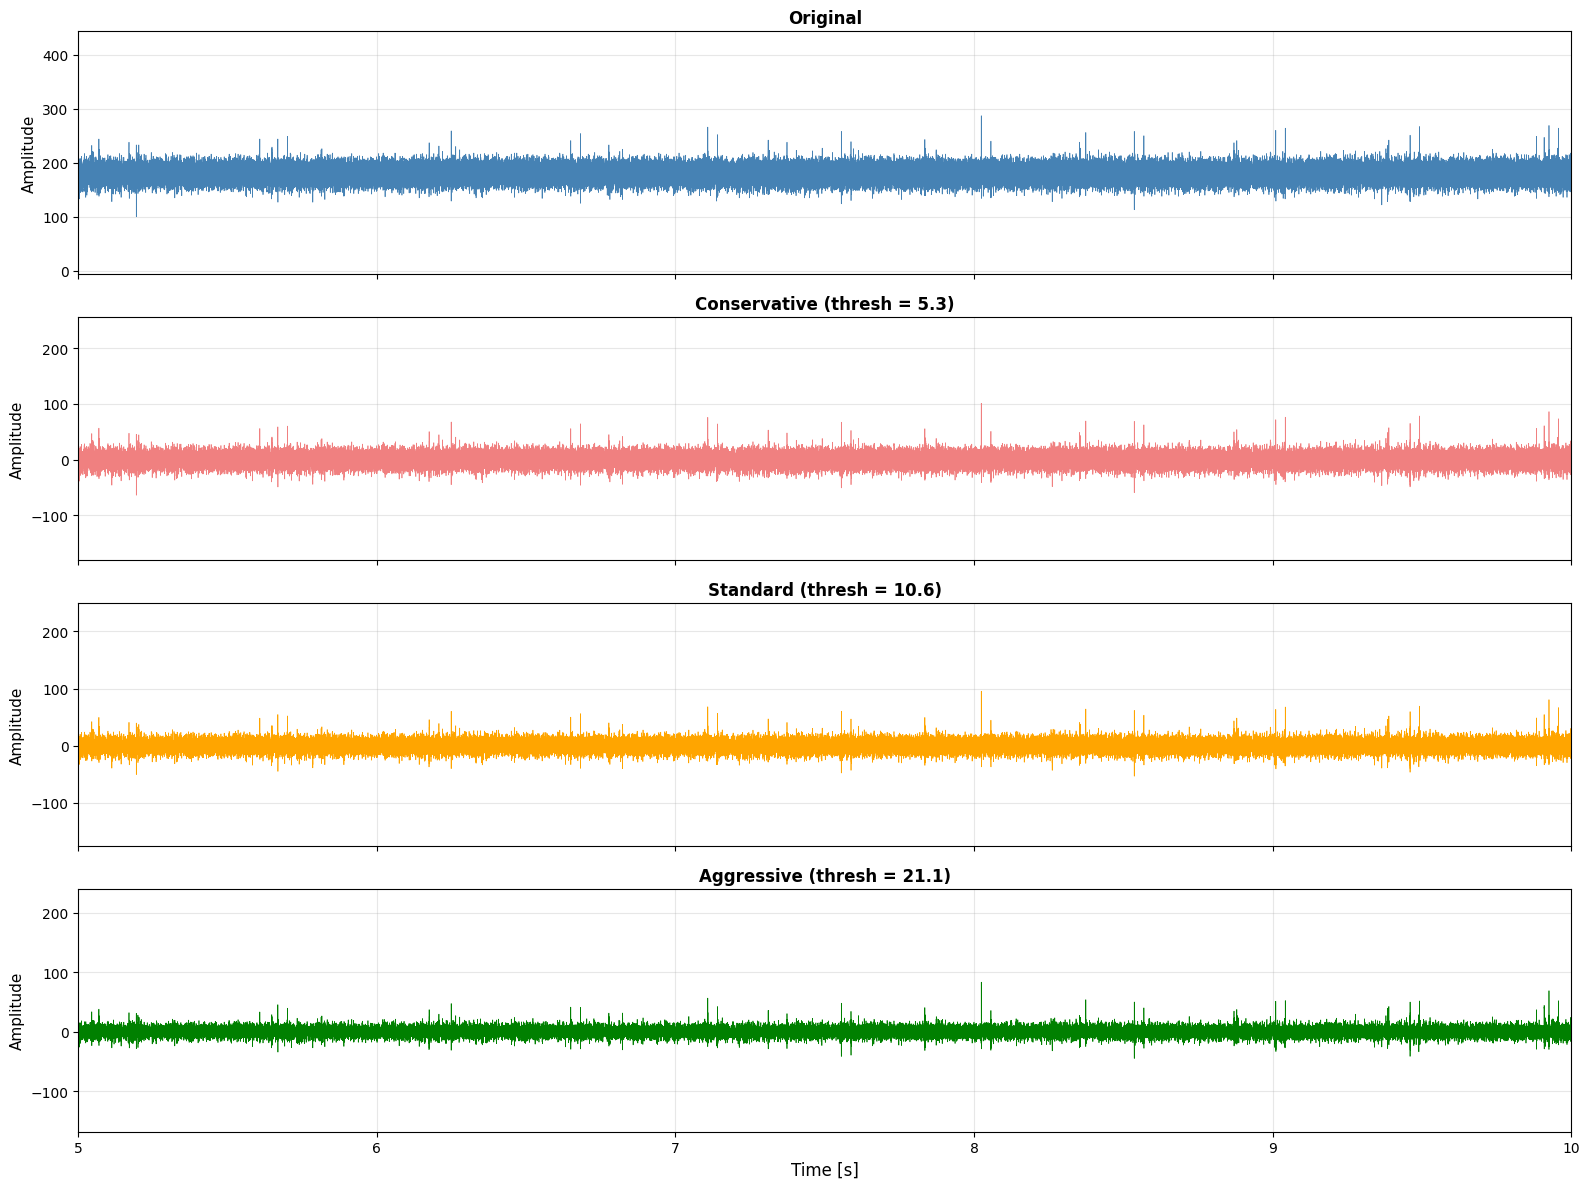

In [9]:
# Calculate automatic threshold first
_, auto_thresh = dolphain.wavelet_denoise(acoustic_data, return_threshold=True)

# Try different thresholds
conservative = dolphain.wavelet_denoise(acoustic_data, thresh=auto_thresh * 0.5)
standard = dolphain.wavelet_denoise(acoustic_data, thresh=auto_thresh)
aggressive = dolphain.wavelet_denoise(acoustic_data, thresh=auto_thresh * 2)

# Plot comparison
fig, axes = plt.subplots(4, 1, figsize=(16, 12), sharex=True)

xlim = (5, 10)
time = np.linspace(0, data['duration'], len(acoustic_data))

axes[0].plot(time, acoustic_data, linewidth=0.5, color='steelblue')
axes[0].set_ylabel('Amplitude', fontsize=11)
axes[0].set_title('Original', fontsize=12, fontweight='bold')
axes[0].grid(True, alpha=0.3)

axes[1].plot(time, conservative, linewidth=0.5, color='lightcoral')
axes[1].set_ylabel('Amplitude', fontsize=11)
axes[1].set_title(f'Conservative (thresh = {auto_thresh*0.5:.1f})', fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.3)

axes[2].plot(time, standard, linewidth=0.5, color='orange')
axes[2].set_ylabel('Amplitude', fontsize=11)
axes[2].set_title(f'Standard (thresh = {auto_thresh:.1f})', fontsize=12, fontweight='bold')
axes[2].grid(True, alpha=0.3)

axes[3].plot(time, aggressive, linewidth=0.5, color='green')
axes[3].set_xlabel('Time [s]', fontsize=12)
axes[3].set_ylabel('Amplitude', fontsize=11)
axes[3].set_title(f'Aggressive (thresh = {auto_thresh*2:.1f})', fontsize=12, fontweight='bold')
axes[3].grid(True, alpha=0.3)

axes[0].set_xlim(xlim)

plt.tight_layout()
plt.show()

## Example 7: Analyzing a Different File

Let's try denoising on a different file type to see how the method generalizes.

In [10]:
# Load the .130 file which may have different characteristics
file_path_2 = Path('fourier_examples/data/7164403B.130')
data_2 = dolphain.read_ears_file(file_path_2)

dolphain.print_file_info(data_2, file_path_2)

File: fourier_examples/data/7164403B.130
Recording start: 2017-06-14 11:02:02.037500
Recording end: 2017-06-14 11:02:23.370833
Duration: 21.33 seconds
Number of samples: 4,096,000
Sampling rate: 192,000 Hz


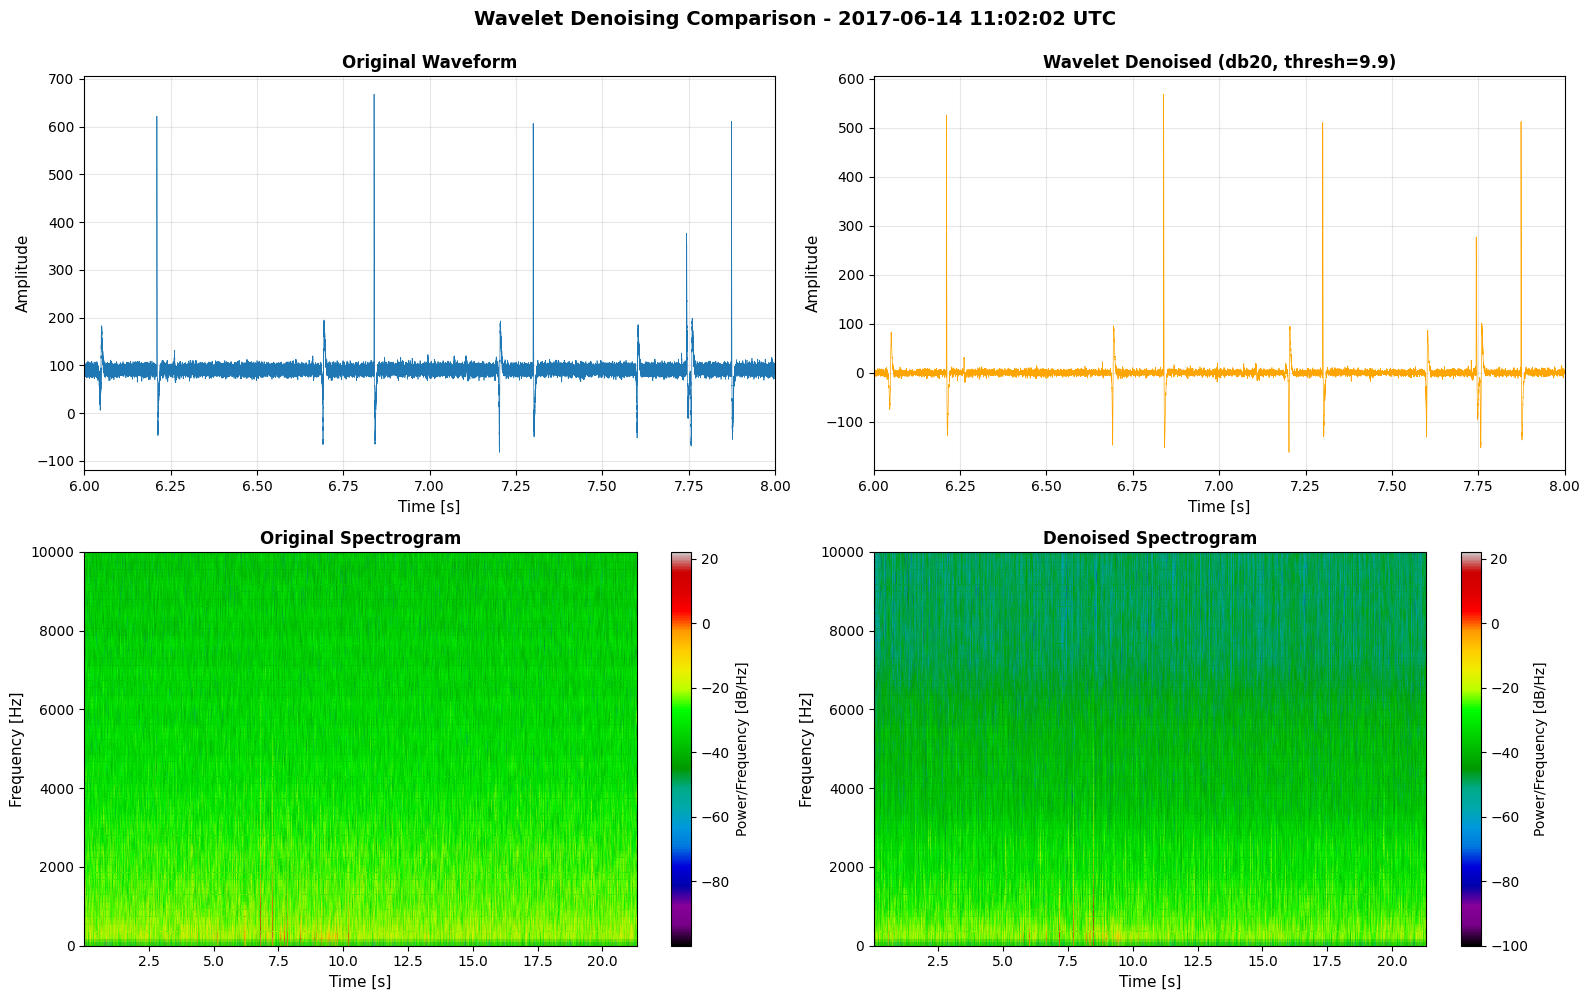

In [11]:
# Apply wavelet denoising and compare
dolphain.plot_denoising_comparison(data_2, xlim=(6, 8), fmax=10000)

## Example 8: Statistical Analysis of Denoising

Let's quantify the effect of denoising on signal statistics.

In [12]:
# Analyze the effect of denoising on signal statistics
original = data['data']
denoised = dolphain.wavelet_denoise(original)

print("Statistical Comparison:")
print("=" * 60)
print(f"{'Metric':<30} {'Original':>12} {'Denoised':>12}")
print("=" * 60)
print(f"{'Mean':<30} {np.mean(original):>12.2f} {np.mean(denoised):>12.2f}")
print(f"{'Std Deviation':<30} {np.std(original):>12.2f} {np.std(denoised):>12.2f}")
print(f"{'RMS':<30} {np.sqrt(np.mean(original**2)):>12.2f} {np.sqrt(np.mean(denoised**2)):>12.2f}")
print(f"{'Peak Amplitude':<30} {np.max(np.abs(original)):>12.2f} {np.max(np.abs(denoised)):>12.2f}")
print(f"{'Variance':<30} {np.var(original):>12.2f} {np.var(denoised):>12.2f}")
print("=" * 60)

# Calculate SNR improvement (simplified estimate)
noise_estimate = original - denoised
snr_improvement = 10 * np.log10(np.var(original) / np.var(noise_estimate))
print(f"\nEstimated SNR improvement: {snr_improvement:.2f} dB")

Statistical Comparison:
Metric                             Original     Denoised
Mean                                 179.89         0.00
Std Deviation                         11.22         8.37
RMS                                  180.24         8.37
Peak Amplitude                       423.00       230.28
Variance                             125.96        70.11

Estimated SNR improvement: 7.89 dB


## Example 9: Working with Denoised Data

Once you're satisfied with the denoising, you can create a new data structure with the cleaned data and use it with all the standard plotting functions.

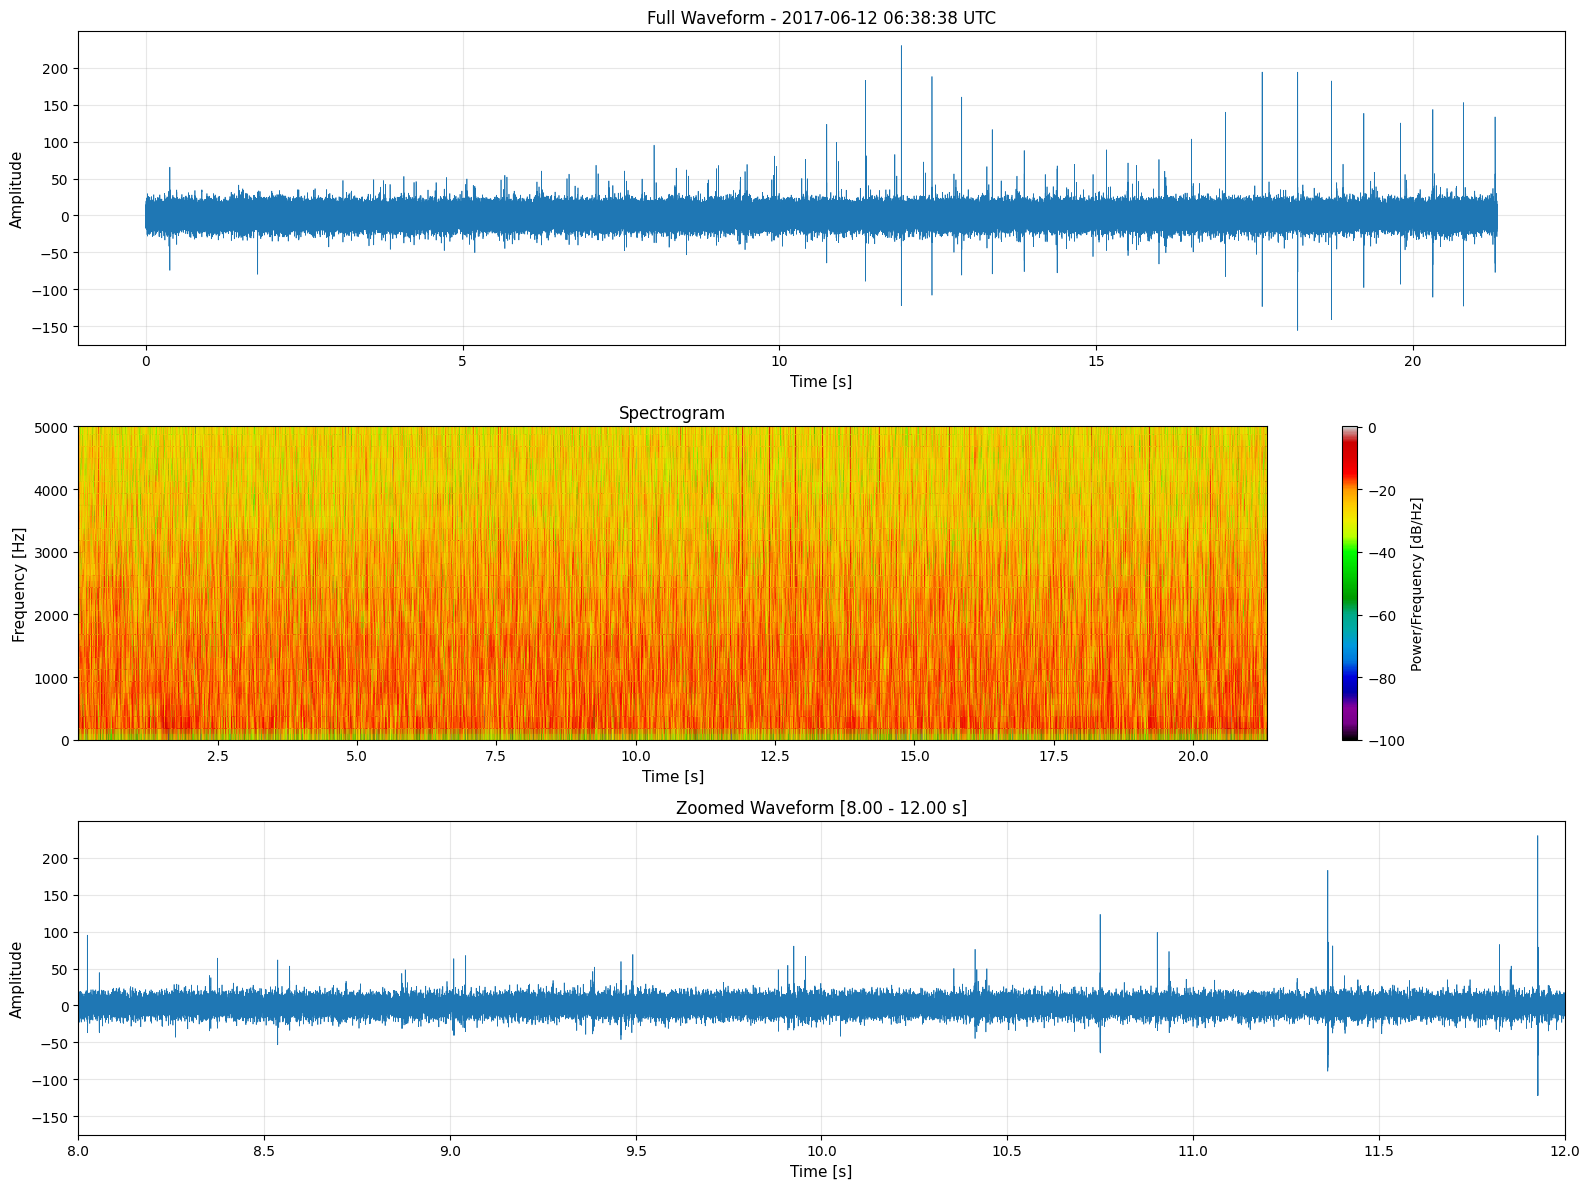

In [13]:
# Create a new data dictionary with denoised data
data_denoised = data.copy()
data_denoised['data'] = dolphain.wavelet_denoise(data['data'])

# Now you can use all the plotting functions with denoised data
dolphain.plot_overview(data_denoised, fmax=5000, xlim_zoom=(8, 12))

## Example 10: Batch Processing

Here's an example of how you might process multiple files with wavelet denoising.

In [14]:
# Example: Process multiple files
from pathlib import Path

def process_file(file_path, output_dir=None):
    """
    Process a single EARS file with wavelet denoising.
    
    Parameters
    ----------
    file_path : Path
        Path to input file
    output_dir : Path, optional
        Directory to save results
    
    Returns
    -------
    dict
        Processing results including threshold and SNR improvement
    """
    # Read file
    data = dolphain.read_ears_file(file_path)
    
    # Denoise
    original = data['data']
    denoised, threshold = dolphain.wavelet_denoise(
        original, 
        return_threshold=True
    )
    
    # Calculate metrics
    noise_estimate = original - denoised
    snr_improvement = 10 * np.log10(np.var(original) / np.var(noise_estimate))
    
    results = {
        'file': file_path.name,
        'threshold': threshold,
        'snr_improvement_db': snr_improvement,
        'original_rms': np.sqrt(np.mean(original**2)),
        'denoised_rms': np.sqrt(np.mean(denoised**2)),
    }
    
    print(f"Processed {file_path.name}:")
    print(f"  Threshold: {threshold:.2f}")
    print(f"  SNR improvement: {snr_improvement:.2f} dB")
    
    return results

# Example usage (commented out to avoid errors if files don't exist)
# results = process_file(Path('unophysics/sample_data/71621DC7.190'))

print("\nBatch processing example defined. Uncomment the line above to run.")


Batch processing example defined. Uncomment the line above to run.


## Key Takeaways

### When to Use Wavelet Denoising

✅ **Good for:**
- Signals with transient features (clicks, pops, pulses)
- Non-stationary noise
- Preserving sharp discontinuities
- Broadband signals with localized events

❌ **Less suitable for:**
- Narrowband signals (use frequency-domain filtering instead)
- When exact phase relationships are critical
- Very low SNR (wavelet denoising has limits)

### Best Practices

1. **Start with defaults**: `db20` wavelet and automatic threshold work well for most acoustic data
2. **Visualize results**: Always check time-domain and spectrograms to ensure important features are preserved
3. **Compare wavelets**: Try different wavelets if default results aren't satisfactory
4. **Adjust threshold**: Use custom thresholds for fine-tuning (typically 0.5× to 2× automatic)
5. **Use soft thresholding**: Generally produces smoother, more natural results

### Technical Details

- **Automatic threshold** uses the Universal Threshold (VisuShrink) method
- **σ estimation** via Median Absolute Deviation (MAD) of finest-scale coefficients
- **Daubechies wavelets** (db4-db20) are asymmetric with good localization
- **Symlets** (sym4-sym8) offer near-symmetry with similar properties

## References

1. Donoho, D. L., & Johnstone, I. M. (1994). Ideal spatial adaptation by wavelet shrinkage. *Biometrika*, 81(3), 425-455.
2. Mallat, S. (2008). *A Wavelet Tour of Signal Processing* (3rd ed.). Academic Press.
3. PyWavelets Documentation: https://pywavelets.readthedocs.io/
4. Donoho, D. L. (1995). De-noising by soft-thresholding. *IEEE Trans. Inf. Theory*, 41(3), 613-627.